In [ ]:
!pip install tweepy
!pip install yfinance
!pip install pandas-datareader>=0.7
!pip install snscrape
!pip install yahoo-historical
!pip install category-encoders

## Imports & API Setup

In [ ]:
import numpy as np
import pandas as pd
import snscrape.modules.twitter as sntwitter
import tweepy, csv, random, datetime, itertools, re
import matplotlib.pyplot as mlpt
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from pandas_datareader import data as pdr
from datetime import date, datetime, timedelta
import yfinance as yf

yf.pdr_override()
pd.set_option('display.max_columns', None)

In [ ]:
CONSUMER_KEY    = '3jmA1BqasLHfItBXj3KnAIGFB'
CONSUMER_SECRET = 'imyEeVTctFZuK62QHmL1I0AUAMudg5HKJDfkx0oR7oFbFinbvA'
ACCESS_TOKEN  = '265857263-pF1DRxgIcxUbxEEFtLwLODPzD3aMl6d4zOKlMnme'
ACCESS_TOKEN_SECRET = 'uUFoOOGeNJfOYD3atlcmPtaxxniXxQzAU4ESJLopA1lbC'

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
# Helpers
def Merge2(dict1, dict2):
  res = {**dict1, **dict2}
  return res
  
def Merge3(dict1, dict2, dict3):
  res = {**dict1, **dict2, **dict3}
  return res

def findWholeWord(s, w):
  return (' ' + w + ' ') in (' ' + s + ' ')

## Yahoo Finance Data Fetch

In [ ]:
def getDataFromYahoo(stock, date):
  dateObj = datetime.strptime(date, '%Y-%m-%d')
  lower = dateObj.strftime("%Y-%m-%d")
  higher = (dateObj + timedelta(days=1)).strftime("%Y-%m-%d")
  stockData = pdr.get_data_yahoo(tickers=stock, start=lower, end=higher)
  res = {}
  if len(stockData) > 0:
    res['Open'] = stockData.iloc[0]['Open']
    res['High'] = stockData.iloc[0]['High']
    res['Low'] = stockData.iloc[0]['Low']
    res['Close'] = stockData.iloc[0]['Close']
    res['Adj Close'] = stockData.iloc[0]['Adj Close']
    res['Volume'] = stockData.iloc[0]['Volume']
  return res

# Test data
print(getDataFromYahoo('goog', '2021-01-04'))
print(getDataFromYahoo('aapl', '2021-01-04'))
print(getDataFromYahoo('tsla', '2021-01-04'))
print(getDataFromYahoo('fb', '2021-01-04'))


[*********************100%***********************]  1 of 1 completed
{'Open': 1757.5400390625, 'High': 1760.6500244140625, 'Low': 1707.8499755859375, 'Close': 1728.239990234375, 'Adj Close': 1728.239990234375, 'Volume': 1901900.0}
[*********************100%***********************]  1 of 1 completed
{'Open': 133.52000427246094, 'High': 133.61000061035156, 'Low': 126.76000213623047, 'Close': 129.41000366210938, 'Adj Close': 129.2169189453125, 'Volume': 143301900.0}
[*********************100%***********************]  1 of 1 completed
{'Open': 719.4600219726562, 'High': 744.489990234375, 'Low': 717.1900024414062, 'Close': 729.77001953125, 'Adj Close': 729.77001953125, 'Volume': 48638200.0}
[*********************100%***********************]  1 of 1 completed
{'Open': 274.7799987792969, 'High': 275.0, 'Low': 265.20001220703125, 'Close': 268.94000244140625, 'Adj Close': 268.94000244140625, 'Volume': 15106100.0}


In [ ]:
from yahoo_historical import Fetcher

stock = 'FB'
data = Fetcher(stock, [2019,1,1], [2020,1,1]).get_historical()
data['stock'] = stock
data.to_csv(stock + '.csv')
print(data)

           Date        Open        High         Low       Close   Adj Close  \
0    2019-01-02  128.990005  137.509995  128.559998  135.679993  135.679993   
1    2019-01-03  134.690002  137.169998  131.119995  131.740005  131.740005   
2    2019-01-04  134.009995  138.000000  133.750000  137.949997  137.949997   
3    2019-01-07  137.559998  138.869995  135.910004  138.050003  138.050003   
4    2019-01-08  139.889999  143.139999  139.539993  142.529999  142.529999   
..          ...         ...         ...         ...         ...         ...   
247  2019-12-24  206.300003  206.789993  205.000000  205.119995  205.119995   
248  2019-12-26  205.570007  207.820007  205.309998  207.789993  207.789993   
249  2019-12-27  208.669998  208.929993  206.589996  208.100006  208.100006   
250  2019-12-30  207.860001  207.899994  203.899994  204.410004  204.410004   
251  2019-12-31  204.000000  205.559998  203.600006  205.250000  205.250000   

       Volume stock  
0    28146200    FB  
1    22

In [ ]:
from yahoo_historical import Fetcher

# stock = 'FB'
# data = Fetcher(stock, [2019,1,1], [2020,1,1]).get_historical()
# data['stock'] = stock
# print(data)

chosen_stocks = pd.read_csv ('stock_tickers.csv', sep=r'\s*,\s*', header=0)
stock_names = chosen_stocks['ticker'].tolist()
dataframes = []
for stock in stock_names:
  try:
    data = Fetcher(stock, [2019,1,1], [2020,1,1]).get_historical()
    data['stock'] = stock
    dataframes.append(data)
  except:
    pass

data = pd.concat(dataframes)
data.to_csv('stock_price.csv')

## Sentiment Analysis

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

sentiment_intensity_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
def performSentimentAnalysis(sentence):
  res = {}
  sentiment = sentiment_intensity_analyzer.polarity_scores(sentence)
  res['Compound'] = sentiment['compound']
  res['Negative'] = sentiment['neg']
  res['Neutral'] = sentiment['neu']
  res['Positive'] = sentiment['pos']
  return res

print(performSentimentAnalysis('Die you fucking asshole!'))
print(performSentimentAnalysis('I love you, stay awesome!'))
print(performSentimentAnalysis('This is so sad I wish this had never happened'))
print(performSentimentAnalysis('Dogecoin to the moon'))
print(performSentimentAnalysis('Cardano sucks, I am moving to Binance'))
print(performSentimentAnalysis('I hate this'))
print(performSentimentAnalysis('I HATE THIS'))
print(performSentimentAnalysis('I HATE THIS!!!!'))

{'Compound': -0.636, 'Negative': 0.583, 'Neutral': 0.417, 'Positive': 0.0}
{'Compound': 0.8622, 'Negative': 0.0, 'Neutral': 0.189, 'Positive': 0.811}
{'Compound': -0.253, 'Negative': 0.286, 'Neutral': 0.501, 'Positive': 0.213}
{'Compound': 0.0, 'Negative': 0.0, 'Neutral': 1.0, 'Positive': 0.0}
{'Compound': -0.3612, 'Negative': 0.333, 'Neutral': 0.667, 'Positive': 0.0}
{'Compound': -0.5719, 'Negative': 0.787, 'Neutral': 0.213, 'Positive': 0.0}
{'Compound': -0.5719, 'Negative': 0.787, 'Neutral': 0.213, 'Positive': 0.0}
{'Compound': -0.7067, 'Negative': 0.83, 'Neutral': 0.17, 'Positive': 0.0}


## Fetch all tweets from specified users (Old way)

Require stock_tickers.csv file from https://s3-ap-southeast-1.amazonaws.com/he-public-data/stock%20tickers251073e.csv

In [ ]:
users = ['MarketWatch', 'business', 'YahooFinance', 'TechCrunch', 'WSJ', 'Forbes',
         'FT', 'TheEconomist', 'nytimes', 'Reuters', 'GerberKawasaki', 'jimcramer',
         'TheStreet', 'TheStalwart', 'TruthGundlach', 'CarlCIcahn', 'ReformedBroker',
         'benbernanke', 'bespokeinvest', 'BespokeCrypto', 'stlouisfed', 'federalreserve',
         'GoldmanSachs', 'ianbremmer', 'MorganStanley', 'AswathDamodaran', 'mcuban',
         'muddywatersre', 'StockTwits', 'SeanaNSmith']

for username in users:
  fetch_tweets = tweepy.Cursor(api.user_timeline, screen_name=username,
                              lang ="en", tweet_mode="extended").items()
  data = pd.DataFrame(data=[[tweet_info.created_at.date(),
                             re.sub('[^ a-zA-Z0-9]', '', tweet_info.full_text),
                             username] 
                            for tweet_info in fetch_tweets], columns=['Date', 'Tweets', 'Username'])
  data.to_csv("Tweets_" + username + ".csv")

In [ ]:
chosen_stocks = pd.read_csv ('stock_tickers.csv', sep=r'\s*,\s*', header=0)
stock_names = chosen_stocks['name'].tolist()
for i in range(len(stock_names)):
  stock_names[i] = stock_names[i].lower()

data = pd.concat([pd.read_csv('Tweets_' + user + '.csv') for user in users ])
final_data = pd.DataFrame(columns=['Date', 'Tweets', 'Username', 'FollowersCount', 'Stock'])
for row in data.itertuples():
  tweet_content = str(row.Tweets).lower()
  stock_found = False
  i = 0
  for stock in stock_names:
    if findWholeWord(tweet_content, stock) or findWholeWord(tweet_content, chosen_stocks.iloc[i]['ticker']):
      stock_found = True
      break
    i = i + 1
  if stock_found is False:
    continue

  day_val = getDataFromYahoo(chosen_stocks.iloc[i]['ticker'], row.Date)
  if len(day_val) == 0:
    continue
  sentiment_val = performSentimentAnalysis(row.Tweets)
  followers_count = api.get_user(row.Username).followers_count
  final_data = final_data.append(Merge3(day_val, sentiment_val,
                                                {'Date': row.Date,
                                                 'Tweets': row.Tweets,
                                                 'Username': row.Username,
                                                 'FollowersCount': followers_count,
                                                 'Stock': chosen_stocks.iloc[i]['ticker']}),
                                 ignore_index=True)
final_data.to_csv("Data.csv")

## Fetch all tweets in 2019 from specified users (New way)


In [ ]:
users = ['MarketWatch', 'business', 'YahooFinance', 'TechCrunch', 'WSJ', 'Forbes',
         'FT', 'TheEconomist', 'nytimes', 'Reuters', 'GerberKawasaki', 'jimcramer',
         'TheStreet', 'TheStalwart', 'TruthGundlach', 'CarlCIcahn', 'ReformedBroker',
         'benbernanke', 'bespokeinvest', 'BespokeCrypto', 'stlouisfed', 'federalreserve',
         'GoldmanSachs', 'ianbremmer', 'MorganStanley', 'AswathDamodaran', 'mcuban',
         'muddywatersre', 'StockTwits', 'SeanaNSmith']

In [ ]:
def fetch_tweets(username):
    scraped_tweets = sntwitter.TwitterUserScraper(username).get_items()
    df = pd.DataFrame(scraped_tweets)[['date', 'content']]
    df = df[(df['date'] > '2019-1-1') & (df['date'] <= '2019-12-31')]
    df.to_csv('Tweets/' + username + '.csv')

for user in users:
  fetch_tweets(user)

In [ ]:
chosen_stocks = pd.read_csv ('stock_tickers.csv', sep=r'\s*,\s*', header=0)

dataframes = []
for user in users:
  df = pd.read_csv('Tweets/' + user + '.csv')

  df['date'] = pd.to_datetime(df["date"]).dt.strftime('%Y-%m-%d')
  df['content'] = ' ' + df['content'].str.replace('\S*@\S*\s?', '').replace('[^a-zA-Z0-9 ]', '') + ' '
  df['content'] = df['content'].str.lower()
  df['username'] = user
  df['followers'] = api.get_user(user).followers_count

  dataframes.append(df)

data = pd.concat(dataframes)
data.drop(data.columns[[0]], axis=1, inplace=True)

dataframes = []
for i in range(len(chosen_stocks)):
  df = data[data.content.str.contains(' ' + chosen_stocks.at[i, 'name'].lower() + ' ')]
  df['stock'] = chosen_stocks.at[i, 'ticker']
  dataframes.append(df)

data = pd.concat(dataframes)
data.to_csv("tweets.csv")
print(data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


             date                                            content  \
37071  2019-01-03   novavax shares jump after positive results fo...   
29846  2019-03-14   the wildly successful invesco qqq trust has a...   
25777  2019-03-10   the invesco qqq trust is now the sixth-larges...   
20     2019-12-30   apple stock is rising toward a record even as...   
579    2019-12-23   apple iphone demand will soar in 2020 with la...   
...           ...                                                ...   
1857   2019-09-06   the charts of yum! brands could use a rest be...   
13128  2019-05-01   yum! brands $yum reports earnings: \n- gaap e...   
1862   2019-10-23   check out francine lai on talking with about ...   
4902   2019-02-15   we have zoetis tonight- and we talk rescue an...   
4933   2019-02-14   absolute out- of- body experience for me. at ...   

             username  followers stock  
37071     MarketWatch    4004317  NVAX  
29846     MarketWatch    4004317   QQQ  
25777       

## Applying NLP & Yahoo Finance API

In [ ]:
tweets = pd.read_csv('tweets.csv')
tweets.drop(tweets.columns[[0]], axis=1, inplace=True)
price = pd.read_csv('stock_price.csv')
price = price.rename(columns={'Date': 'date', 'Open': 'open', 'High': 'high',
                              'Low': 'low', 'Adj Close': 'adjClose', 'Close': 'close', 'Volume': 'volume'})
price.drop(price.columns[[0, 9, 10, 11, 12, 13, 14]], axis=1, inplace=True)
data = pd.merge(tweets, price, how='left', on=['date', 'stock'])

data['compound'] = ''
data['negative'] = ''
data['neutral'] = ''
data['positive'] = ''
print(data)

             date                                            content  \
0      2019-01-03   novavax shares jump after positive results fo...   
1      2019-03-14   the wildly successful invesco qqq trust has a...   
2      2019-03-10   the invesco qqq trust is now the sixth-larges...   
3      2019-12-30   apple stock is rising toward a record even as...   
4      2019-12-23   apple iphone demand will soar in 2020 with la...   
...           ...                                                ...   
86125  2019-09-06   the charts of yum! brands could use a rest be...   
86126  2019-05-01   yum! brands $yum reports earnings: \n- gaap e...   
86127  2019-10-23   check out francine lai on talking with about ...   
86128  2019-02-15   we have zoetis tonight- and we talk rescue an...   
86129  2019-02-14   absolute out- of- body experience for me. at ...   

             username  followers stock        open        high         low  \
0         MarketWatch    4004317  NVAX   38.599998   42.4

In [ ]:
for i in data.index:
  res = performSentimentAnalysis(data.loc[i, 'content'])
  data.at[i, 'compound'] = res['Compound']
  data.at[i, 'negative'] = res['Negative']
  data.at[i, 'neutral'] = res['Neutral']
  data.at[i, 'positive'] = res['Positive']

nan_value = float("NaN")
data.replace("", nan_value, inplace=True)
data.dropna(subset = ['open', 'high', 'low', 'close', 'adjClose', 'volume'], inplace=True)
data.to_csv("Data.csv")
print(data)

             date                                            content  \
0      2019-01-03   novavax shares jump after positive results fo...   
1      2019-03-14   the wildly successful invesco qqq trust has a...   
3      2019-12-30   apple stock is rising toward a record even as...   
4      2019-12-23   apple iphone demand will soar in 2020 with la...   
5      2019-12-20   can you smell what the rock is hawking? apple...   
...           ...                                                ...   
86125  2019-09-06   the charts of yum! brands could use a rest be...   
86126  2019-05-01   yum! brands $yum reports earnings: \n- gaap e...   
86127  2019-10-23   check out francine lai on talking with about ...   
86128  2019-02-15   we have zoetis tonight- and we talk rescue an...   
86129  2019-02-14   absolute out- of- body experience for me. at ...   

             username  followers stock        open        high         low  \
0         MarketWatch    4004317  NVAX   38.599998   42.4

## Analysis

In [ ]:
dataset = pd.read_csv('Data.csv')
followers = dataset.pop('followers')
dataset = dataset.sort_values(by='date')  # Maintain order of date for training in q1, q2 and testing in q3
dataset['followers'] = followers
dataset['delta'] = dataset['close'] - dataset['open']
for col in dataset.columns:
  if col not in ['followers', 'stock', 'compound', 'delta']:
    del dataset[col]

print(dataset)

      stock  compound  followers     delta
332    AAPL    0.2960    4004317  0.757500
50435   USB   -0.5859   18795687  1.129997
50436   USB   -0.2500   18795687  1.129997
38406   USB    0.6808    4004317  1.129997
38407   USB   -0.6249    4004317  1.129997
...     ...       ...        ...       ...
52339   USB   -0.2960   23336191 -0.390003
52338   USB   -0.6808   23336191 -0.390003
52337   USB   -0.4404   23336191 -0.390003
35596   TGT   -0.3612   23336191 -0.110001
35594   TGT    0.0000   23336191 -0.110001

[69980 rows x 4 columns]


In [ ]:
q1 = dataset.apply(lambda x: True if x['compound'] >= 0.05 and x['delta'] > 0 else False , axis=1)
print(len(q1[q1 == True].index))

q2 = dataset.apply(lambda x: True if x['compound'] >= 0.05 and x['delta'] < 0 else False , axis=1)
print(len(q2[q2 == True].index))

13580
11812


In [ ]:
import category_encoders as ce
# encoder = ce.OneHotEncoder(cols='stock', handle_unknown='return_nan', return_df=True, use_cat_names=True)
encoder = ce.OrdinalEncoder(cols=['stock'])
dataset = encoder.fit_transform(dataset)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

% of positive tweets=  36.49757073449557
% of negative tweets=  31.260360102886537
% of neutral tweets=  32.242069162617895


[]

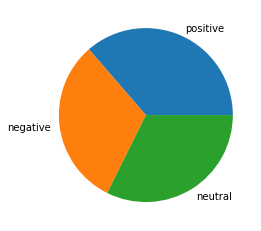

In [ ]:
pos, neg, neu = 0, 0, 0
for i in range(0, len(dataset)):
  get_val = dataset.compound[i]
  if (float(get_val) <= -0.05):
    neg = neg + 1
  elif (float(get_val) >= 0.05):
    pos = pos + 1
  else:
    neu = neu + 1

pos_v = (pos / len(dataset)) * 100
neg_v = (neg / len(dataset)) * 100
neu_v = (neu / len(dataset)) * 100
print("% of positive tweets= ", pos_v)
print("% of negative tweets= ", neg_v)
print("% of neutral tweets= ", neu_v)
arr = np.asarray([pos_v, neg_v, neu_v], dtype=int)
mlpt.pie(arr, labels=['positive', 'negative', 'neutral'])
mlpt.plot()

In [ ]:
print(dataset['delta'].max())
print(dataset['followers'].max())

73.93005399999993
49804251


In [ ]:
print(X)

[[ 1.0000000e+00  2.9600000e-01  4.0043170e+06]
 [ 2.0000000e+00 -5.8590000e-01  1.8795687e+07]
 [ 2.0000000e+00 -2.5000000e-01  1.8795687e+07]
 ...
 [ 2.0000000e+00 -4.4040000e-01  2.3336191e+07]
 [ 5.0000000e+00 -3.6120000e-01  2.3336191e+07]
 [ 5.0000000e+00  0.0000000e+00  2.3336191e+07]]


In [ ]:
print(y)

[ 0.7575    1.129997  1.129997 ... -0.390003 -0.110001 -0.110001]


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 1, shuffle=False)
print(X_train)

[[ 1.0000000e+00  2.9600000e-01  4.0043170e+06]
 [ 2.0000000e+00 -5.8590000e-01  1.8795687e+07]
 [ 2.0000000e+00 -2.5000000e-01  1.8795687e+07]
 ...
 [ 1.0000000e+01 -5.8590000e-01  4.9804251e+07]
 [ 2.0000000e+00  0.0000000e+00  2.3336191e+07]
 [ 2.0000000e+00  0.0000000e+00  2.3336191e+07]]


In [ ]:
print(X_test)

[[ 2.0000000e+00 -7.5790000e-01  2.3336191e+07]
 [ 2.0000000e+00 -2.7320000e-01  2.3336191e+07]
 [ 2.0000000e+00  0.0000000e+00  2.3336191e+07]
 ...
 [ 2.0000000e+00 -4.4040000e-01  2.3336191e+07]
 [ 5.0000000e+00 -3.6120000e-01  2.3336191e+07]
 [ 5.0000000e+00  0.0000000e+00  2.3336191e+07]]


In [ ]:
print(X_train.shape)
print(X_test.shape)

(46886, 3)
(23094, 3)


In [ ]:
print(y_train)

[0.7575   1.129997 1.129997 ... 9.25     0.780003 0.780003]
